In [10]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal
import pandas as pd

# I use the work of Eric Yu to help me build this algorithm. Link: https://github.com/ericyangyu/PPO-for-Beginners

In [11]:
#2) Set up Neural Network functions and classes

class Model_PPO(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, np_inputs, nb_outputs):
        super(Model_PPO, self).__init__()   
        self.layer1 = nn.Linear(np_inputs, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, nb_outputs)
        torch.nn.init.uniform_(self.layer3.weight,0.003, 0.006)

    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [12]:
#3) Rollout on the environment:

class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        for ep in range(nbr_episodes):
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(action.dim()==0):
                        action=torch.unsqueeze(action,dim=0)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    #action_all=np.append(action_all,np.argmax(action[1:4].detach().numpy()))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action_all)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float)
    
    def iterations_rand(self,actor_net, cov_mat, batch_size):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param cov_mat: covariance matrix used for exploration
        :param batch_size: batch size
        :return: Tensors; state batch, action batch, log_proba batch
        """
        t = 0
        while t<batch_size:
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                t += 1
                with torch.no_grad():
                    parameters_based = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(parameters_based.dim()==0):
                        parameters_based=torch.unsqueeze(parameters_based,dim=0)
                    distribution_p = MultivariateNormal(parameters_based, cov_mat)
                    action = distribution_p.sample()
                    log_proba = distribution_p.log_prob(action)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action.detach().numpy())
                    self.batch_log_probs.append(log_proba)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float), torch.tensor(self.batch_log_probs, dtype=torch.float)

    def immediate_rewards(self):
        """
        Immediate rewards
        :return: Tensor; batch reward
        """
        batch_rewards = []
        for ep_rews in self.batch_rews:
            for rew in reversed(ep_rews):
                batch_rewards.insert(0,rew)
        return torch.tensor(batch_rewards, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Expected futures rewards
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs = []
        for ep_rews in reversed(self.batch_rews):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs.insert(0,episodic_reward)
        return torch.tensor(batch_rtgs, dtype=torch.float)

In [13]:
#4) Algorithm DDPG:
class Algo_PPO():
    """ 
    PPO algorithm : training and testing
    :param policy_class: policy (actor model)
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class(self.num_states, self.num_actions)
        self.critic_net = policy_class(self.num_states, 1)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.change_std=0.0
        self.value_std=0.50
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
        self.cov_mat = torch.diag(self.cov_var)
        self.rollout = Env_rollout(env, self.max_steps)
        self.ep_reward_list=[]
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        rew_batch = self.rollout.immediate_rewards()
        return state_batch, action_batch, rew_batch
        
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: number of batch iterations
        """
        self.change_std=self.value_std/float(nb_loop)
        for ep in range(nb_loop):
            state_batch,action_batch,log_prob_batch = self.rollout.iterations_rand(self.actor_net,self.cov_mat,self.batch_size)
            batch_rtgs = self.rollout.futur_rewards()
            #self.value_std=max(self.value_std-self.change_std,0.1)
            #self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
            #self.cov_mat = torch.diag(self.cov_var)
            self.rollout.reset()
            for i in range(10):
                V_batch = torch.squeeze(self.critic_net(state_batch))
                advantage_batch = batch_rtgs - V_batch
                advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)
                
                parameters_batch = torch.squeeze(self.actor_net(state_batch).unsqueeze(-1))
                if(parameters_batch.dim()==1):
                        parameters_batch=torch.unsqueeze(parameters_batch,dim=1)
                distribution_p = MultivariateNormal(parameters_batch, self.cov_mat)
                log_prob_current_batch = distribution_p.log_prob(action_batch)
                ratio_batch = torch.exp(log_prob_current_batch - log_prob_batch)
                ratio_loss = torch.mul(ratio_batch,advantage_batch)
                clip_loss = torch.mul(torch.clamp(ratio_loss, 0.8, 1.2),advantage_batch)
                actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

                criterion=nn.MSELoss(reduction='mean')
                critic_loss = criterion(V_batch.float(), batch_rtgs.float())
                self.optimizer_actor.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimizer_actor.step()
                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                self.optimizer_critic.step()
                
            state_batch, action_batch = self.rollout.iterations(self.actor_net, 30)
            batch_rews = self.rollout.immediate_rewards()
            self.ep_reward_list.append(batch_rews.mean().numpy())
            avg_reward = np.mean(self.ep_reward_list[-10:])
            self.rollout.reset()
            
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep*self.batch_size ))
            self.total_loop= self.total_loop +1
        path='load_model/parameters/ppo-{num_algo:02d}-{name}-step-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.batch_size = 2000
        self.gamma = 0.99
        self.critic_lr = 3e-4
        self.actor_lr = 3e-4
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: number of total batch iterations
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/ppo-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/ppo-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
    
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/ppo-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        torch.save(self.actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/ppo-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        torch.save(self.critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 

In [14]:
#5) Computing part:
# Import environment
problem = "Crosswalk_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,1000)

In [15]:
algo.loading(1,1000)

In [50]:
#Training
import time
start = time.process_time()
algo.train(1000)
algo.saving()
end = time.process_time()
print("Running time: "+str(end-start))

Accident!
Accident!
Episode * 0 * Avg Reward is ==> -10.034659385681152 And Number of steps is ==> 0
Episode * 1 * Avg Reward is ==> -9.876619338989258 And Number of steps is ==> 2000
Episode * 2 * Avg Reward is ==> -9.866986274719238 And Number of steps is ==> 4000
Episode * 3 * Avg Reward is ==> -10.43532943725586 And Number of steps is ==> 6000
Episode * 4 * Avg Reward is ==> -9.982044219970703 And Number of steps is ==> 8000
Episode * 5 * Avg Reward is ==> -10.28724193572998 And Number of steps is ==> 10000
Episode * 6 * Avg Reward is ==> -10.983170509338379 And Number of steps is ==> 12000
Episode * 7 * Avg Reward is ==> -11.080268859863281 And Number of steps is ==> 14000
Episode * 8 * Avg Reward is ==> -10.930810928344727 And Number of steps is ==> 16000
Episode * 9 * Avg Reward is ==> -10.709348678588867 And Number of steps is ==> 18000
Episode * 10 * Avg Reward is ==> -10.446874618530273 And Number of steps is ==> 20000
Accident!
Episode * 11 * Avg Reward is ==> -10.1912403106

Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 71 * Avg Reward is ==> -4.824444770812988 And Number of steps is ==> 142000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 72 * Avg Reward is ==> -4.779249668121338 And Number of steps is ==> 144000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 73 * Avg Reward is ==> -4.929808616638184 And Number of steps is ==> 146000
Accident!
Accident!
Episode * 74 * Avg Reward is ==> -4.841128349304199 And Number of steps is ==> 148000
Accident!
Accident!
Accident!
Accident!
Episode * 75 * Avg Reward is ==> -4.84047794342041 And Number of steps is ==> 150000
Accident!
Accident!
Accident!
Accident!
Episode * 76 * Avg Reward is ==> -4.41993522644043 And Number of steps is ==> 152000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 77 * Avg Reward is ==> -4.44447660446167 And Number of steps is ==> 154000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
E

Accident!
Accident!
Accident!
Episode * 137 * Avg Reward is ==> -3.2564151287078857 And Number of steps is ==> 274000
Episode * 138 * Avg Reward is ==> -3.1340889930725098 And Number of steps is ==> 276000
Accident!
Accident!
Episode * 139 * Avg Reward is ==> -3.0602028369903564 And Number of steps is ==> 278000
Accident!
Episode * 140 * Avg Reward is ==> -3.02185320854187 And Number of steps is ==> 280000
Accident!
Accident!
Accident!
Episode * 141 * Avg Reward is ==> -2.9220478534698486 And Number of steps is ==> 282000
Accident!
Accident!
Accident!
Accident!
Episode * 142 * Avg Reward is ==> -2.847705364227295 And Number of steps is ==> 284000
Accident!
Accident!
Accident!
Episode * 143 * Avg Reward is ==> -2.9911656379699707 And Number of steps is ==> 286000
Accident!
Accident!
Episode * 144 * Avg Reward is ==> -2.891223430633545 And Number of steps is ==> 288000
Accident!
Episode * 145 * Avg Reward is ==> -3.0637173652648926 And Number of steps is ==> 290000
Accident!
Accident!
Ep

Episode * 218 * Avg Reward is ==> -1.255188226699829 And Number of steps is ==> 436000
Episode * 219 * Avg Reward is ==> -1.2483047246932983 And Number of steps is ==> 438000
Accident!
Episode * 220 * Avg Reward is ==> -1.1818130016326904 And Number of steps is ==> 440000
Accident!
Episode * 221 * Avg Reward is ==> -1.1700681447982788 And Number of steps is ==> 442000
Episode * 222 * Avg Reward is ==> -1.1602623462677002 And Number of steps is ==> 444000
Episode * 223 * Avg Reward is ==> -1.153700590133667 And Number of steps is ==> 446000
Episode * 224 * Avg Reward is ==> -1.13289475440979 And Number of steps is ==> 448000
Accident!
Accident!
Episode * 225 * Avg Reward is ==> -1.2167127132415771 And Number of steps is ==> 450000
Episode * 226 * Avg Reward is ==> -1.22696852684021 And Number of steps is ==> 452000
Accident!
Episode * 227 * Avg Reward is ==> -1.307866096496582 And Number of steps is ==> 454000
Accident!
Episode * 228 * Avg Reward is ==> -1.4088850021362305 And Number of

Episode * 304 * Avg Reward is ==> -0.9432257413864136 And Number of steps is ==> 608000
Episode * 305 * Avg Reward is ==> -0.7543700933456421 And Number of steps is ==> 610000
Episode * 306 * Avg Reward is ==> -0.7712757587432861 And Number of steps is ==> 612000
Episode * 307 * Avg Reward is ==> -0.7772363424301147 And Number of steps is ==> 614000
Accident!
Episode * 308 * Avg Reward is ==> -0.7933051586151123 And Number of steps is ==> 616000
Episode * 309 * Avg Reward is ==> -0.7891771793365479 And Number of steps is ==> 618000
Episode * 310 * Avg Reward is ==> -0.7958256006240845 And Number of steps is ==> 620000
Episode * 311 * Avg Reward is ==> -0.7322231531143188 And Number of steps is ==> 622000
Episode * 312 * Avg Reward is ==> -0.6926089525222778 And Number of steps is ==> 624000
Episode * 313 * Avg Reward is ==> -0.6396093964576721 And Number of steps is ==> 626000
Accident!
Episode * 314 * Avg Reward is ==> -0.6875276565551758 And Number of steps is ==> 628000
Episode * 31

Episode * 395 * Avg Reward is ==> -0.6527277231216431 And Number of steps is ==> 790000
Episode * 396 * Avg Reward is ==> -0.631388783454895 And Number of steps is ==> 792000
Episode * 397 * Avg Reward is ==> -0.6311548948287964 And Number of steps is ==> 794000
Episode * 398 * Avg Reward is ==> -0.6173349618911743 And Number of steps is ==> 796000
Episode * 399 * Avg Reward is ==> -0.6224551796913147 And Number of steps is ==> 798000
Accident!
Episode * 400 * Avg Reward is ==> -0.6123128533363342 And Number of steps is ==> 800000
Episode * 401 * Avg Reward is ==> -0.6149603128433228 And Number of steps is ==> 802000
Accident!
Episode * 402 * Avg Reward is ==> -0.6524818539619446 And Number of steps is ==> 804000
Episode * 403 * Avg Reward is ==> -0.6281424164772034 And Number of steps is ==> 806000
Episode * 404 * Avg Reward is ==> -0.6372910737991333 And Number of steps is ==> 808000
Episode * 405 * Avg Reward is ==> -0.626038670539856 And Number of steps is ==> 810000
Episode * 406 

Episode * 486 * Avg Reward is ==> -0.5830951929092407 And Number of steps is ==> 972000
Episode * 487 * Avg Reward is ==> -0.5767512917518616 And Number of steps is ==> 974000
Accident!
Episode * 488 * Avg Reward is ==> -0.5935498476028442 And Number of steps is ==> 976000
Episode * 489 * Avg Reward is ==> -0.5820635557174683 And Number of steps is ==> 978000
Episode * 490 * Avg Reward is ==> -0.5889281034469604 And Number of steps is ==> 980000
Episode * 491 * Avg Reward is ==> -0.612309992313385 And Number of steps is ==> 982000
Episode * 492 * Avg Reward is ==> -0.6081370115280151 And Number of steps is ==> 984000
Episode * 493 * Avg Reward is ==> -0.6126302480697632 And Number of steps is ==> 986000
Accident!
Episode * 494 * Avg Reward is ==> -0.6992059946060181 And Number of steps is ==> 988000
Accident!
Episode * 495 * Avg Reward is ==> -0.6903473734855652 And Number of steps is ==> 990000
Episode * 496 * Avg Reward is ==> -0.6818038821220398 And Number of steps is ==> 992000
Epi

Episode * 576 * Avg Reward is ==> -0.5672215819358826 And Number of steps is ==> 1152000
Episode * 577 * Avg Reward is ==> -0.5606289505958557 And Number of steps is ==> 1154000
Episode * 578 * Avg Reward is ==> -0.5626729726791382 And Number of steps is ==> 1156000
Episode * 579 * Avg Reward is ==> -0.5739314556121826 And Number of steps is ==> 1158000
Episode * 580 * Avg Reward is ==> -0.5814885497093201 And Number of steps is ==> 1160000
Episode * 581 * Avg Reward is ==> -0.5750738978385925 And Number of steps is ==> 1162000
Episode * 582 * Avg Reward is ==> -0.5798158049583435 And Number of steps is ==> 1164000
Episode * 583 * Avg Reward is ==> -0.5631085634231567 And Number of steps is ==> 1166000
Episode * 584 * Avg Reward is ==> -0.5463075637817383 And Number of steps is ==> 1168000
Episode * 585 * Avg Reward is ==> -0.551664412021637 And Number of steps is ==> 1170000
Episode * 586 * Avg Reward is ==> -0.5572605133056641 And Number of steps is ==> 1172000
Episode * 587 * Avg Re

Episode * 668 * Avg Reward is ==> -0.6482340693473816 And Number of steps is ==> 1336000
Episode * 669 * Avg Reward is ==> -0.6511499285697937 And Number of steps is ==> 1338000
Episode * 670 * Avg Reward is ==> -0.6329095959663391 And Number of steps is ==> 1340000
Accident!
Episode * 671 * Avg Reward is ==> -0.6286797523498535 And Number of steps is ==> 1342000
Episode * 672 * Avg Reward is ==> -0.6226128339767456 And Number of steps is ==> 1344000
Episode * 673 * Avg Reward is ==> -0.6042577028274536 And Number of steps is ==> 1346000
Episode * 674 * Avg Reward is ==> -0.6098428964614868 And Number of steps is ==> 1348000
Accident!
Episode * 675 * Avg Reward is ==> -0.6103786826133728 And Number of steps is ==> 1350000
Episode * 676 * Avg Reward is ==> -0.6022199988365173 And Number of steps is ==> 1352000
Episode * 677 * Avg Reward is ==> -0.640531063079834 And Number of steps is ==> 1354000
Episode * 678 * Avg Reward is ==> -0.6391768455505371 And Number of steps is ==> 1356000
Ep

Episode * 760 * Avg Reward is ==> -0.5339636206626892 And Number of steps is ==> 1520000
Episode * 761 * Avg Reward is ==> -0.5216299891471863 And Number of steps is ==> 1522000
Episode * 762 * Avg Reward is ==> -0.5125380158424377 And Number of steps is ==> 1524000
Episode * 763 * Avg Reward is ==> -0.506025493144989 And Number of steps is ==> 1526000
Episode * 764 * Avg Reward is ==> -0.5183852910995483 And Number of steps is ==> 1528000
Episode * 765 * Avg Reward is ==> -0.5275875329971313 And Number of steps is ==> 1530000
Episode * 766 * Avg Reward is ==> -0.5218572020530701 And Number of steps is ==> 1532000
Episode * 767 * Avg Reward is ==> -0.5322795510292053 And Number of steps is ==> 1534000
Accident!
Episode * 768 * Avg Reward is ==> -0.5305684208869934 And Number of steps is ==> 1536000
Episode * 769 * Avg Reward is ==> -0.5368325114250183 And Number of steps is ==> 1538000
Episode * 770 * Avg Reward is ==> -0.5452240705490112 And Number of steps is ==> 1540000
Episode * 77

Episode * 852 * Avg Reward is ==> -0.5317729711532593 And Number of steps is ==> 1704000
Episode * 853 * Avg Reward is ==> -0.5331933498382568 And Number of steps is ==> 1706000
Episode * 854 * Avg Reward is ==> -0.5438138246536255 And Number of steps is ==> 1708000
Episode * 855 * Avg Reward is ==> -0.5759356617927551 And Number of steps is ==> 1710000
Episode * 856 * Avg Reward is ==> -0.5840533375740051 And Number of steps is ==> 1712000
Episode * 857 * Avg Reward is ==> -0.6097906827926636 And Number of steps is ==> 1714000
Episode * 858 * Avg Reward is ==> -0.6338835954666138 And Number of steps is ==> 1716000
Episode * 859 * Avg Reward is ==> -0.6336773633956909 And Number of steps is ==> 1718000
Episode * 860 * Avg Reward is ==> -0.6380342245101929 And Number of steps is ==> 1720000
Episode * 861 * Avg Reward is ==> -0.6371274590492249 And Number of steps is ==> 1722000
Episode * 862 * Avg Reward is ==> -0.6271606087684631 And Number of steps is ==> 1724000
Episode * 863 * Avg R

Episode * 944 * Avg Reward is ==> -0.6152240037918091 And Number of steps is ==> 1888000
Episode * 945 * Avg Reward is ==> -0.6205981969833374 And Number of steps is ==> 1890000
Episode * 946 * Avg Reward is ==> -0.6147392988204956 And Number of steps is ==> 1892000
Episode * 947 * Avg Reward is ==> -0.6215137243270874 And Number of steps is ==> 1894000
Accident!
Episode * 948 * Avg Reward is ==> -0.6176117658615112 And Number of steps is ==> 1896000
Episode * 949 * Avg Reward is ==> -0.6083478927612305 And Number of steps is ==> 1898000
Episode * 950 * Avg Reward is ==> -0.60023033618927 And Number of steps is ==> 1900000
Episode * 951 * Avg Reward is ==> -0.5866397619247437 And Number of steps is ==> 1902000
Episode * 952 * Avg Reward is ==> -0.5772315263748169 And Number of steps is ==> 1904000
Episode * 953 * Avg Reward is ==> -0.5816065073013306 And Number of steps is ==> 1906000
Episode * 954 * Avg Reward is ==> -0.5642953515052795 And Number of steps is ==> 1908000
Episode * 955

Episode * 1035 * Avg Reward is ==> -0.5308910608291626 And Number of steps is ==> 2070000
Episode * 1036 * Avg Reward is ==> -0.5211254358291626 And Number of steps is ==> 2072000
Episode * 1037 * Avg Reward is ==> -0.5399891138076782 And Number of steps is ==> 2074000
Episode * 1038 * Avg Reward is ==> -0.5596539974212646 And Number of steps is ==> 2076000
Episode * 1039 * Avg Reward is ==> -0.5687124729156494 And Number of steps is ==> 2078000
Episode * 1040 * Avg Reward is ==> -0.5791104435920715 And Number of steps is ==> 2080000
Episode * 1041 * Avg Reward is ==> -0.5583146810531616 And Number of steps is ==> 2082000
Accident!
Episode * 1042 * Avg Reward is ==> -0.5557969808578491 And Number of steps is ==> 2084000
Episode * 1043 * Avg Reward is ==> -0.5451448559761047 And Number of steps is ==> 2086000
Episode * 1044 * Avg Reward is ==> -0.5576469302177429 And Number of steps is ==> 2088000
Episode * 1045 * Avg Reward is ==> -0.5454737544059753 And Number of steps is ==> 2090000


Episode * 1125 * Avg Reward is ==> -0.5624043345451355 And Number of steps is ==> 2250000
Episode * 1126 * Avg Reward is ==> -0.5693114399909973 And Number of steps is ==> 2252000
Episode * 1127 * Avg Reward is ==> -0.5764486789703369 And Number of steps is ==> 2254000
Episode * 1128 * Avg Reward is ==> -0.5836774706840515 And Number of steps is ==> 2256000
Episode * 1129 * Avg Reward is ==> -0.5939282178878784 And Number of steps is ==> 2258000
Episode * 1130 * Avg Reward is ==> -0.5980024337768555 And Number of steps is ==> 2260000
Episode * 1131 * Avg Reward is ==> -0.6157549619674683 And Number of steps is ==> 2262000
Episode * 1132 * Avg Reward is ==> -0.6295996904373169 And Number of steps is ==> 2264000
Episode * 1133 * Avg Reward is ==> -0.6137807369232178 And Number of steps is ==> 2266000
Accident!
Accident!
Episode * 1134 * Avg Reward is ==> -0.6182001233100891 And Number of steps is ==> 2268000
Episode * 1135 * Avg Reward is ==> -0.6030938029289246 And Number of steps is ==

Episode * 1216 * Avg Reward is ==> -0.586753249168396 And Number of steps is ==> 2432000
Episode * 1217 * Avg Reward is ==> -0.587527871131897 And Number of steps is ==> 2434000
Episode * 1218 * Avg Reward is ==> -0.570493221282959 And Number of steps is ==> 2436000
Episode * 1219 * Avg Reward is ==> -0.5635382533073425 And Number of steps is ==> 2438000
Episode * 1220 * Avg Reward is ==> -0.5826197862625122 And Number of steps is ==> 2440000
Episode * 1221 * Avg Reward is ==> -0.5850924253463745 And Number of steps is ==> 2442000
Episode * 1222 * Avg Reward is ==> -0.6008158922195435 And Number of steps is ==> 2444000
Episode * 1223 * Avg Reward is ==> -0.6022793650627136 And Number of steps is ==> 2446000
Episode * 1224 * Avg Reward is ==> -0.5783416032791138 And Number of steps is ==> 2448000
Episode * 1225 * Avg Reward is ==> -0.5452747344970703 And Number of steps is ==> 2450000
Episode * 1226 * Avg Reward is ==> -0.5571421384811401 And Number of steps is ==> 2452000
Episode * 122

Accident!
Episode * 1307 * Avg Reward is ==> -0.6362017393112183 And Number of steps is ==> 2614000
Episode * 1308 * Avg Reward is ==> -0.6244920492172241 And Number of steps is ==> 2616000
Accident!
Accident!
Accident!
Episode * 1309 * Avg Reward is ==> -0.6299263834953308 And Number of steps is ==> 2618000
Episode * 1310 * Avg Reward is ==> -0.6306192278862 And Number of steps is ==> 2620000
Episode * 1311 * Avg Reward is ==> -0.6379208564758301 And Number of steps is ==> 2622000
Episode * 1312 * Avg Reward is ==> -0.6273820996284485 And Number of steps is ==> 2624000
Episode * 1313 * Avg Reward is ==> -0.6066097021102905 And Number of steps is ==> 2626000
Episode * 1314 * Avg Reward is ==> -0.5880208015441895 And Number of steps is ==> 2628000
Episode * 1315 * Avg Reward is ==> -0.6108568906784058 And Number of steps is ==> 2630000
Episode * 1316 * Avg Reward is ==> -0.6218927502632141 And Number of steps is ==> 2632000
Episode * 1317 * Avg Reward is ==> -0.5427619218826294 And Numb

Episode * 1398 * Avg Reward is ==> -0.5503693222999573 And Number of steps is ==> 2796000
Episode * 1399 * Avg Reward is ==> -0.545784056186676 And Number of steps is ==> 2798000
Episode * 1400 * Avg Reward is ==> -0.562267541885376 And Number of steps is ==> 2800000
Episode * 1401 * Avg Reward is ==> -0.5569531917572021 And Number of steps is ==> 2802000
Episode * 1402 * Avg Reward is ==> -0.5465282201766968 And Number of steps is ==> 2804000
Episode * 1403 * Avg Reward is ==> -0.5380567908287048 And Number of steps is ==> 2806000
Episode * 1404 * Avg Reward is ==> -0.5113210678100586 And Number of steps is ==> 2808000
Episode * 1405 * Avg Reward is ==> -0.5407218337059021 And Number of steps is ==> 2810000
Episode * 1406 * Avg Reward is ==> -0.542732834815979 And Number of steps is ==> 2812000
Episode * 1407 * Avg Reward is ==> -0.5550286173820496 And Number of steps is ==> 2814000
Episode * 1408 * Avg Reward is ==> -0.5533062219619751 And Number of steps is ==> 2816000
Episode * 140

Episode * 1489 * Avg Reward is ==> -0.45899924635887146 And Number of steps is ==> 2978000
Episode * 1490 * Avg Reward is ==> -0.45816534757614136 And Number of steps is ==> 2980000
Episode * 1491 * Avg Reward is ==> -0.45835137367248535 And Number of steps is ==> 2982000
Episode * 1492 * Avg Reward is ==> -0.47378039360046387 And Number of steps is ==> 2984000
Episode * 1493 * Avg Reward is ==> -0.49598583579063416 And Number of steps is ==> 2986000
Episode * 1494 * Avg Reward is ==> -0.5085656046867371 And Number of steps is ==> 2988000
Episode * 1495 * Avg Reward is ==> -0.5188426971435547 And Number of steps is ==> 2990000
Episode * 1496 * Avg Reward is ==> -0.5143559575080872 And Number of steps is ==> 2992000
Episode * 1497 * Avg Reward is ==> -0.5308777689933777 And Number of steps is ==> 2994000
Episode * 1498 * Avg Reward is ==> -0.5340096950531006 And Number of steps is ==> 2996000
Episode * 1499 * Avg Reward is ==> -0.5257279276847839 And Number of steps is ==> 2998000
Episo

KeyboardInterrupt: 

In [17]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(100)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [59]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 7.03 m/s and its standard deviation is 3.50 m/s

The average car acceleration is 0.02 m/s2 and its standard deviation is 1.84 m/s2

The average pedestrian speed is 1.00 m/s and its standard deviation is 0.36 m/s

The average reward is -0.64 and its standard deviation is 2.05

The average CO2 emission is 22996.73mg and its standard deviation is 8265.20 mg

 Average End-times:
Total: 9.94 s
Car: 4.89 s
Pedestrian: 6.55 s


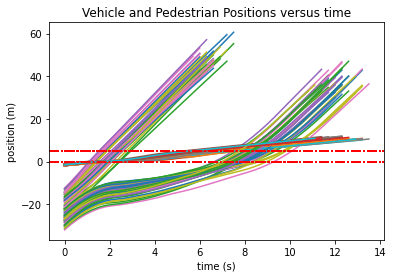

In [18]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

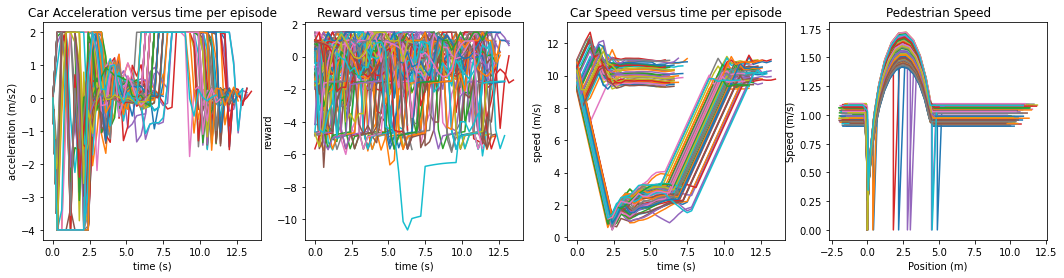

In [19]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [23]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=40

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1

    if(choice):
        min_l=min(t-t_init,size_cross)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_cross):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_cross-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_cross-t+t_init))
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
    else:
        min_l=min(t-t_init,size_wait)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_wait):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_wait-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_wait-t+t_init))
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

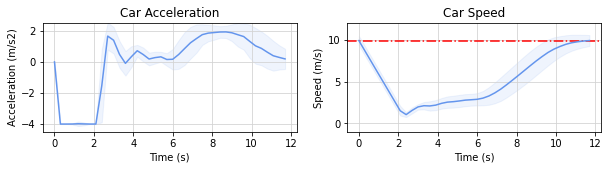

In [26]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_cross_ppo_time_final.pdf")


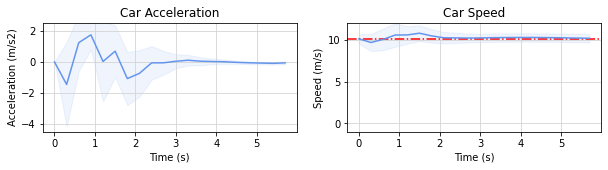

In [27]:
x1=[0.3*i for i in range(size_wait)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_wait_ppo_time_final.pdf")

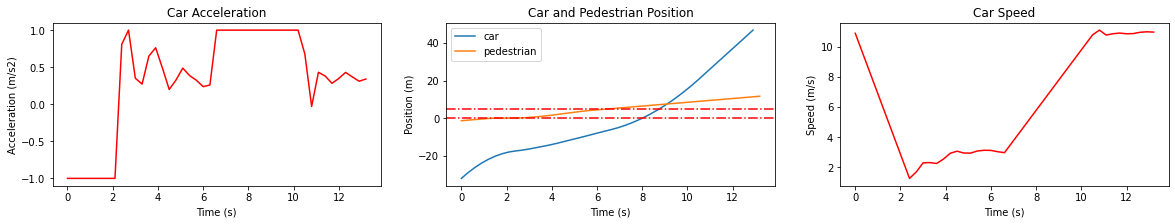

In [36]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-1.1,1.1)
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')
t+=1

In [37]:
def estimation_value(x1,x2,x3,y1,y3):
    a=(y3-y1)/(x3-x1)
    b=(y1*x3 - y3*x1)/(x3-x1)
    return a*x2+b

def extract_estimations(positions, parameter, start_position, end_position, step_pos):
    size_position=int((end_position-start_position)/step_pos)
    length=len(positions)
    array_cross=np.array([0.0]*size_position)
    i_step=0
    i_pos=start_position
    i=0
    while(i_pos<positions[i_step]):
        array_cross[i]=parameter[i_step]
        i=i+1
        i_pos=i_pos+0.5
    while(i_step<length and i<size_position):
        while( i_step+1<length and i_pos>positions[i_step]):
            i_step=i_step+1
        array_cross[i]=estimation_value(positions[i_step-1],i_pos,positions[i_step],parameter[i_step-1],parameter[i_step])
        i=i+1
        i_pos=i_pos+0.5
    while(i<size_position):
        array_cross[i]=parameter[i_step-1]
        i=i+1
    return array_cross

In [38]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
start_position=-32.5
end_position=32.5
while t+1<len(ep_time):
    
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
        
    if(choice):
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
        
    else:
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

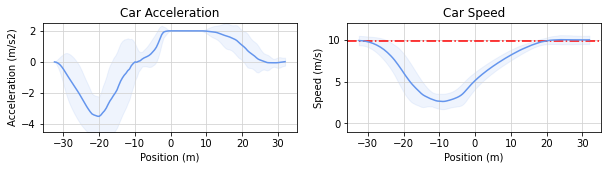

In [40]:
size_position=int((end_position-start_position)/0.5)
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_cross_ppo_pos_final.pdf")

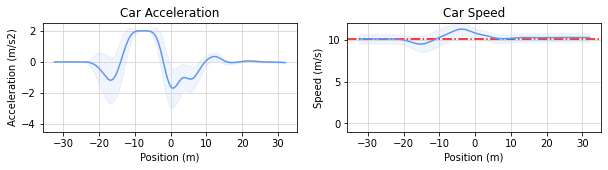

In [41]:
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_wait_ppo_pos_final.pdf")

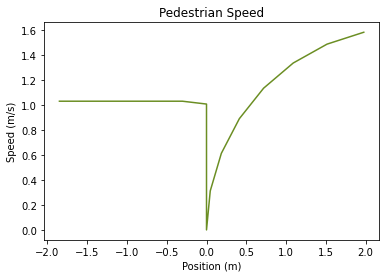

In [50]:
plt.title('Pedestrian Speed')
plt.xlabel("Position (m)")
plt.ylabel("Speed (m/s)")
plt.plot(states[t_init:t-10,4],states[t_init:t-10,3], color='olivedrab')
#plt.savefig("PDF_results/ped_speed.pdf")

In [120]:
#8) Edges Cases: 
#decided, change_speed, stops (with imminent decision)
#decided cases do not work because of the reward structure
problem = "Crosswalk_test-v0"
u_b = [2.0, 11.0, -20.0, 1.1, -1.0]
l_b = [-4.0, 9.0, -25.0, 0.9, -1.5]

env = gym.make(problem,dt=0.3,Vm=2.5,lower_bounds=l_b, upper_bounds=u_b,simulation="sin",initial_mode="stops")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
algo.loading(1,1000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [131]:
states, actions, rewards = algo.evaluate(20)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Accident!


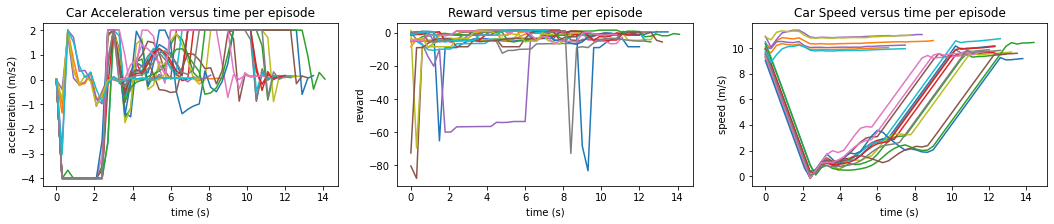

In [132]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


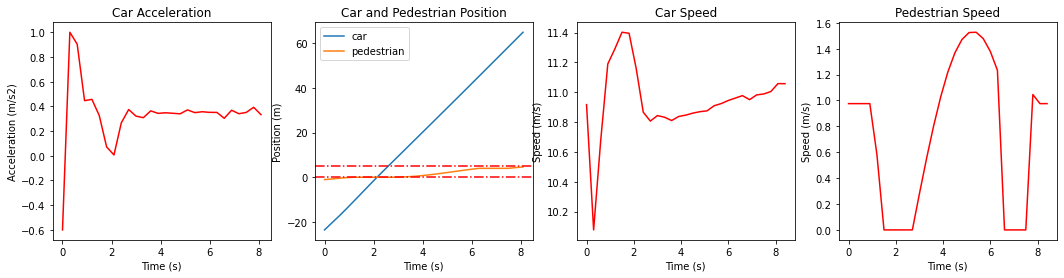

In [147]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t],actions[t_init:t,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t],ep_pos_ped[t_init:t],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Speed (m/s)")
ax4.plot(ep_time[t_init:t+1],ep_speed_ped[t_init:t+1],color='r')
t+=1

In [72]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.42 m/s and its standard deviation is 3.80 m/s

The average car acceleration is 0.01 m/s2 and its standard deviation is 1.86 m/s2

The average pedestrian speed is 0.89 m/s and its standard deviation is 0.46 m/s

The average reward is -4.41 and its standard deviation is 11.58

The average CO2 emission is 25341.15mg and its standard deviation is 6392.51 mg

 Average End-times:
Total: 10.96 s
Car: 5.71 s
Pedestrian: 7.45 s


In [200]:
ep_pos_ped

tensor([-1.1075, -0.7895, -0.4716, -0.1536,  0.0000,  0.0000,  0.0000,  0.0497,
         0.1969,  0.4357,  0.7566,  1.1469,  1.5910,  2.0713,  2.5686,  3.0631,
         3.5353,  3.9663,  4.3390,  4.6569,  4.6569,  4.6569,  4.6569,  4.6569,
         4.6569,  4.9749,  5.2928,  5.6108,  5.9288,  6.2467,  6.5647,  6.8826,
         7.2006,  7.5185,  7.8365,  8.1545,  8.4724,  8.7904,  9.1083,  9.4263,
         9.7442, 10.0622])

In [201]:
ep_pos_car

tensor([-24.6472, -21.8017, -19.3163, -17.1909, -15.4255, -14.0201, -12.9747,
        -12.2893, -11.9368, -11.7428, -11.4974, -11.1388, -10.7052, -10.2616,
         -9.8233,  -9.3588,  -8.8321,  -8.2169,  -7.4921,  -6.6584,  -5.7567,
         -4.8359,  -3.9392,  -3.0559,  -2.0723,  -0.9088,   0.4348,   1.9583,
          3.6619,   5.5454,   7.6089,   9.8525,  12.2760,  14.8796,  17.6631,
         20.6266,  23.6713,  26.6898,  29.6979,  32.7153,  35.7343,  38.7529])